In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from PIL import Image
import numpy as np
import os
import glob

# Preprocess training data

In [3]:
real_path = '/content/drive/My Drive/COS30082/Assignment2/Liveness/Real'
fake_path = '/content/drive/My Drive/COS30082/Assignment2/Liveness/Fake'
IMAGE_SIZE=224
resized_real_path = '/content/drive/My Drive/COS30082/Assignment2/Liveness/Resized/Real'
resized_fake_path = '/content/drive/My Drive/COS30082/Assignment2/Liveness/Resized/Fake'

#### Load the dataset

In [ ]:
os.makedirs(resized_real_path, exist_ok=True)
os.makedirs(resized_fake_path, exist_ok=True)

#### Resize Images

In [ ]:


# Loop through all files in the source directory
for filename in os.listdir(real_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Check for image file extensions
        # Open an image file
        with Image.open(os.path.join(real_path, filename)) as img:
            # Resize the image to IMAGE_SIZE x IMAGE_SIZE
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            # Save the image to the output directory with the same name
            img.save(os.path.join(resized_real_path, filename))


print("Resizing Real complete!")

Resizing Real complete!


In [ ]:
# Loop through all files in the source directory
for filename in os.listdir(fake_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Check for image file extensions
        # Open an image file
        with Image.open(os.path.join(fake_path, filename)) as img:
            # Resize the image to IMAGE_SIZE x IMAGE_SIZE
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            # Save the image to the output directory with the same name
            img.save(os.path.join(resized_fake_path, filename))


print("Resizing Fake complete!")

Resizing Fake complete!


# Load Images

In [5]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in glob.glob(os.path.join(folder, '*.jpg')):  # Change the extension if needed
        img = Image.open(filename)  # Resize to 128x128
        img_array = np.array(img) / 255.0   # Normalize to [0, 1]
        images.append(img_array)
        labels.append(label)
    return images, labels

# Load real and fake images
real_images, real_labels = load_images_from_folder(resized_real_path, 1)  # 1 for real
fake_images, fake_labels = load_images_from_folder(resized_fake_path, 0)  # 0 for fake

In [7]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/My Drive/COS30082/Assignment2/Resized",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    #batch_size = 128,
    class_mode = 'binary'
)

Found 600 images belonging to 2 classes.


In [8]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_generator,
    epochs = 32,
)

Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 595ms/step - accuracy: 0.5801 - loss: 0.8758
Epoch 2/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - accuracy: 0.8435 - loss: 0.3790
Epoch 3/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - accuracy: 0.7988 - loss: 0.3969
Epoch 4/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.8876 - loss: 0.3147
Epoch 5/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.8678 - loss: 0.2849
Epoch 6/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - accuracy: 0.9041 - loss: 0.2324
Epoch 7/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.9156 - loss: 0.2076
Epoch 8/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.9148 - loss: 0.1945
Epoch 9/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.9125 - loss: 0.1852
Epoch 10/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.9430 - loss: 0.1496
Epoch 11/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.9267 - loss: 0.1975
Epoch 12/32
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - a

In [21]:
model.save('liveness_model.h5')

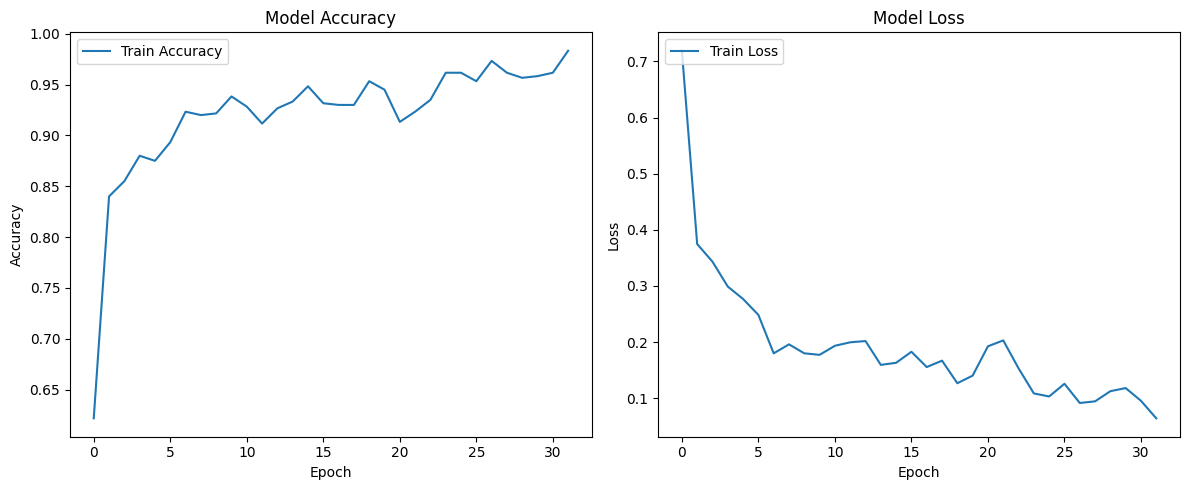

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Test Model

In [13]:
real = Image.open("tam_real_crop.png").convert("RGB")
fake = Image.open("tam_fake_crop.png").convert("RGB")

In [14]:
real_resized = np.array(real.resize((IMAGE_SIZE, IMAGE_SIZE)))
fake_resized = np.array(fake.resize((IMAGE_SIZE, IMAGE_SIZE)))

In [15]:
real_resized_batch = np.expand_dims(real_resized, axis=0) / 255.0
fake_resized_batch = np.expand_dims(fake_resized, axis=0) / 255.0

In [16]:
result_real = model.predict(real_resized_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


In [17]:
result_fake = model.predict(fake_resized_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [18]:
print(result_real)
print(result_fake)

[[0.7444083]]
[[0.463891]]
